# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on mouse PFC cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [ ]:
import numpy as np
import scanpy as sc
import anndata

import time
import os, wget

import cupy as cp
import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
from sh import gunzip
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import rmm

# managed_memory オプションなどで RMM を初期化
rmm.reinitialize(managed_memory=True)

# 現在のデバイスリソースを取得し、その allocate メソッドをアロケータとして設定
current_mr = rmm.mr.get_current_device_resource()
cp.cuda.set_allocator(current_mr.allocate)

import calculation_tool as ct

AttributeError: Module 'rmm' has no attribute 'get_allocator'

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [6]:
import os
import urllib.request
import gzip
import shutil

url_list=[r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482102&format=file&file=GSM5482102%5FPFC%5FWT%5FRep1%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482102&format=file&file=GSM5482102%5FPFC%5FWT%5FRep1%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482102&format=file&file=GSM5482102%5FPFC%5FWT%5FRep1%5Fmatrix%2Emtx%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482103&format=file&file=GSM5482103%5FPFC%5FWT%5FRep2%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482103&format=file&file=GSM5482103%5FPFC%5FWT%5FRep2%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482103&format=file&file=GSM5482103%5FPFC%5FWT%5FRep2%5Fmatrix%2Emtx%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482104&format=file&file=GSM5482104%5FPFC%5FSetd1aHet%5FRep1%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482104&format=file&file=GSM5482104%5FPFC%5FSetd1aHet%5FRep1%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482104&format=file&file=GSM5482104%5FPFC%5FSetd1aHet%5FRep1%5Fmatrix%2Emtx%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482105&format=file&file=GSM5482105%5FPFC%5FSetd1aHet%5FRep2%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482105&format=file&file=GSM5482105%5FPFC%5FSetd1aHet%5FRep2%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482105&format=file&file=GSM5482105%5FPFC%5FSetd1aHet%5FRep2%5Fmatrix%2Emtx%2Egz"]

def download_file(url, dir, file_name):
    full_path = os.path.join(dir, file_name)
    urllib.request.urlretrieve(url, full_path)
    # 以下のコメントアウト部分を活用する場合は、解凍の手順を追加することができます。
    # with gzip.open(full_path, 'rb') as f_in:
    #     with open(full_path[:-3], 'wb') as f_out:
    #         shutil.copyfileobj(f_in, f_out)

dir = "/data/mouse_PFC/"

for url in url_list:
    acc = url.split("acc=")[1].split("&")[0]
    file_name_from_url = url.split("file=")[1]

    # WTとSetd1aHetのサブフォルダを作成
    subfolder = "WT" if "WT" in file_name_from_url else "Setd1aHet"
    acc_dir = os.path.join(dir,subfolder, acc)
    os.makedirs(acc_dir, exist_ok=True)

    # 標準的なファイル名に変更（.gzを取り除く）
    standard_file_name = file_name_from_url.split('_')[-1].replace('.gz', '')
    
    if "barcodes" in file_name_from_url:
        standard_file_name = "barcodes.tsv.gz"
    elif "features" in file_name_from_url:
        standard_file_name = "features.tsv.gz"
    elif "matrix" in file_name_from_url:
        standard_file_name = "matrix.mtx.gz"
    
    # ファイルをダウンロード
    download_file(url, acc_dir, standard_file_name)


In [7]:
# ダウンロードディレクトリ
base_dir = "/data/mouse_PFC/"

def read_10x_mtx(path, label):
    """10x mtxフォーマットのデータを読み込み、指定されたラベルを追加します。"""
    adata = sc.read_10x_mtx(
        path,
        var_names='gene_symbols',
        cache=True
    )
    adata.obs['label'] = label
    return adata

labels = ["WT", "Setd1aHet"]

all_adatas = []

for label in labels:
    label_dir = os.path.join(base_dir, label)
    gsm_dirs = [os.path.join(label_dir, d) for d in os.listdir(label_dir) if os.path.isdir(os.path.join(label_dir, d))]
    
    for gsm_dir in gsm_dirs:
        if os.path.exists(gsm_dir):
            all_adatas.append(read_10x_mtx(gsm_dir, label))

# 全てのAnnDataオブジェクトを1つに結合
combined_adata = all_adatas[0].concatenate(all_adatas[1:], join='outer')

# .h5ad形式で保存
combined_adata.write("/data/mouse_PFC/combined_data.h5ad")

## load data

In [ ]:
file_path="/temp/data/mouse_PFC/combined_data.h5ad"
#adata.write(file_path)
adata = anndata.read_h5ad(file_path)

In [16]:
import calculation_tool as ct
file_path="/temp/data/mouse_PFC/combined_data.h5ad"
adata=ct.preprocess_adata_in_bulk(file_path,label=None)

preprocess_in_bulk


In [4]:
file_path="/temp/data/mouse_PFC/combined_data_processed.h5ad"
adata=anndata.read_h5ad(file_path)

In [8]:
D_R_mtx,GPCR_type_df,drug_list,GPCR_list=ct.load_parameters()
params=ct.set_parameters_for_preprocess(GPCR_list)

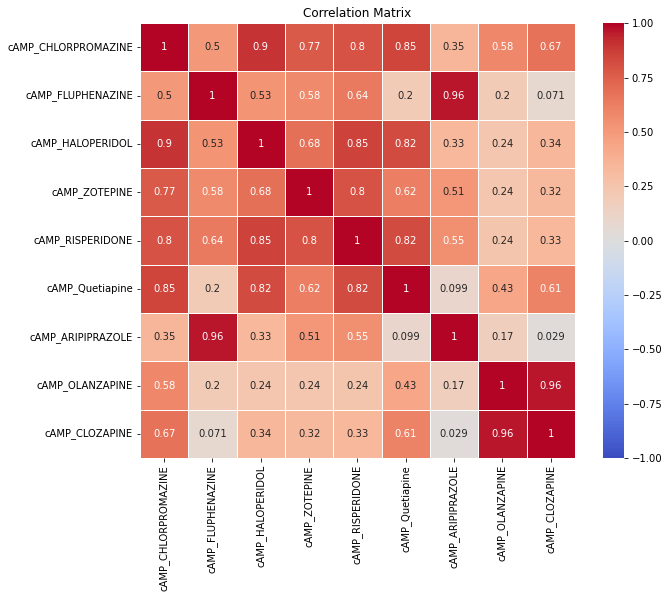

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_matrix(correlation_matrix):
    plt.figure(figsize=(10, 8))  # 画像のサイズを調整します。
    
    # ヒートマップをプロット
    sns.heatmap(
        correlation_matrix, 
        annot=True,       # 数値をセル内に表示
        cmap='coolwarm',  # カラーマップの指定
        vmin=-1, vmax=1, # カラーバーの最小・最大値
        square=True,     # 各セルを正方形にする
        linewidths=.5    # セル間の線の幅
    )

    plt.title("Correlation Matrix")
    plt.show()

# 薬のリストからcAMPのデータカラムを抽出
cAMP_columns = ['cAMP_%s' % drug for drug in drug_list]

# adataのobsからcAMPデータを取得
cAMP_data = adata.obs[cAMP_columns]

# 相関を計算
correlation_matrix = cAMP_data.corr()

# ヒートマップのプロット
plot_correlation_matrix(correlation_matrix)

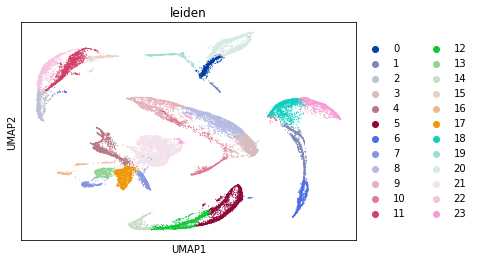

In [10]:
sc.pl.umap(adata, color=["leiden"])

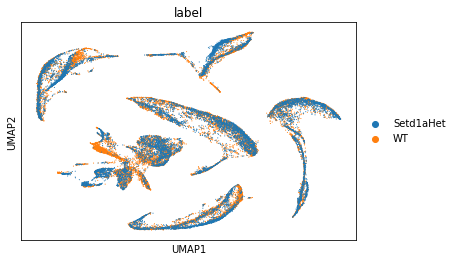

In [12]:
sc.pl.umap(adata, color=["label"])

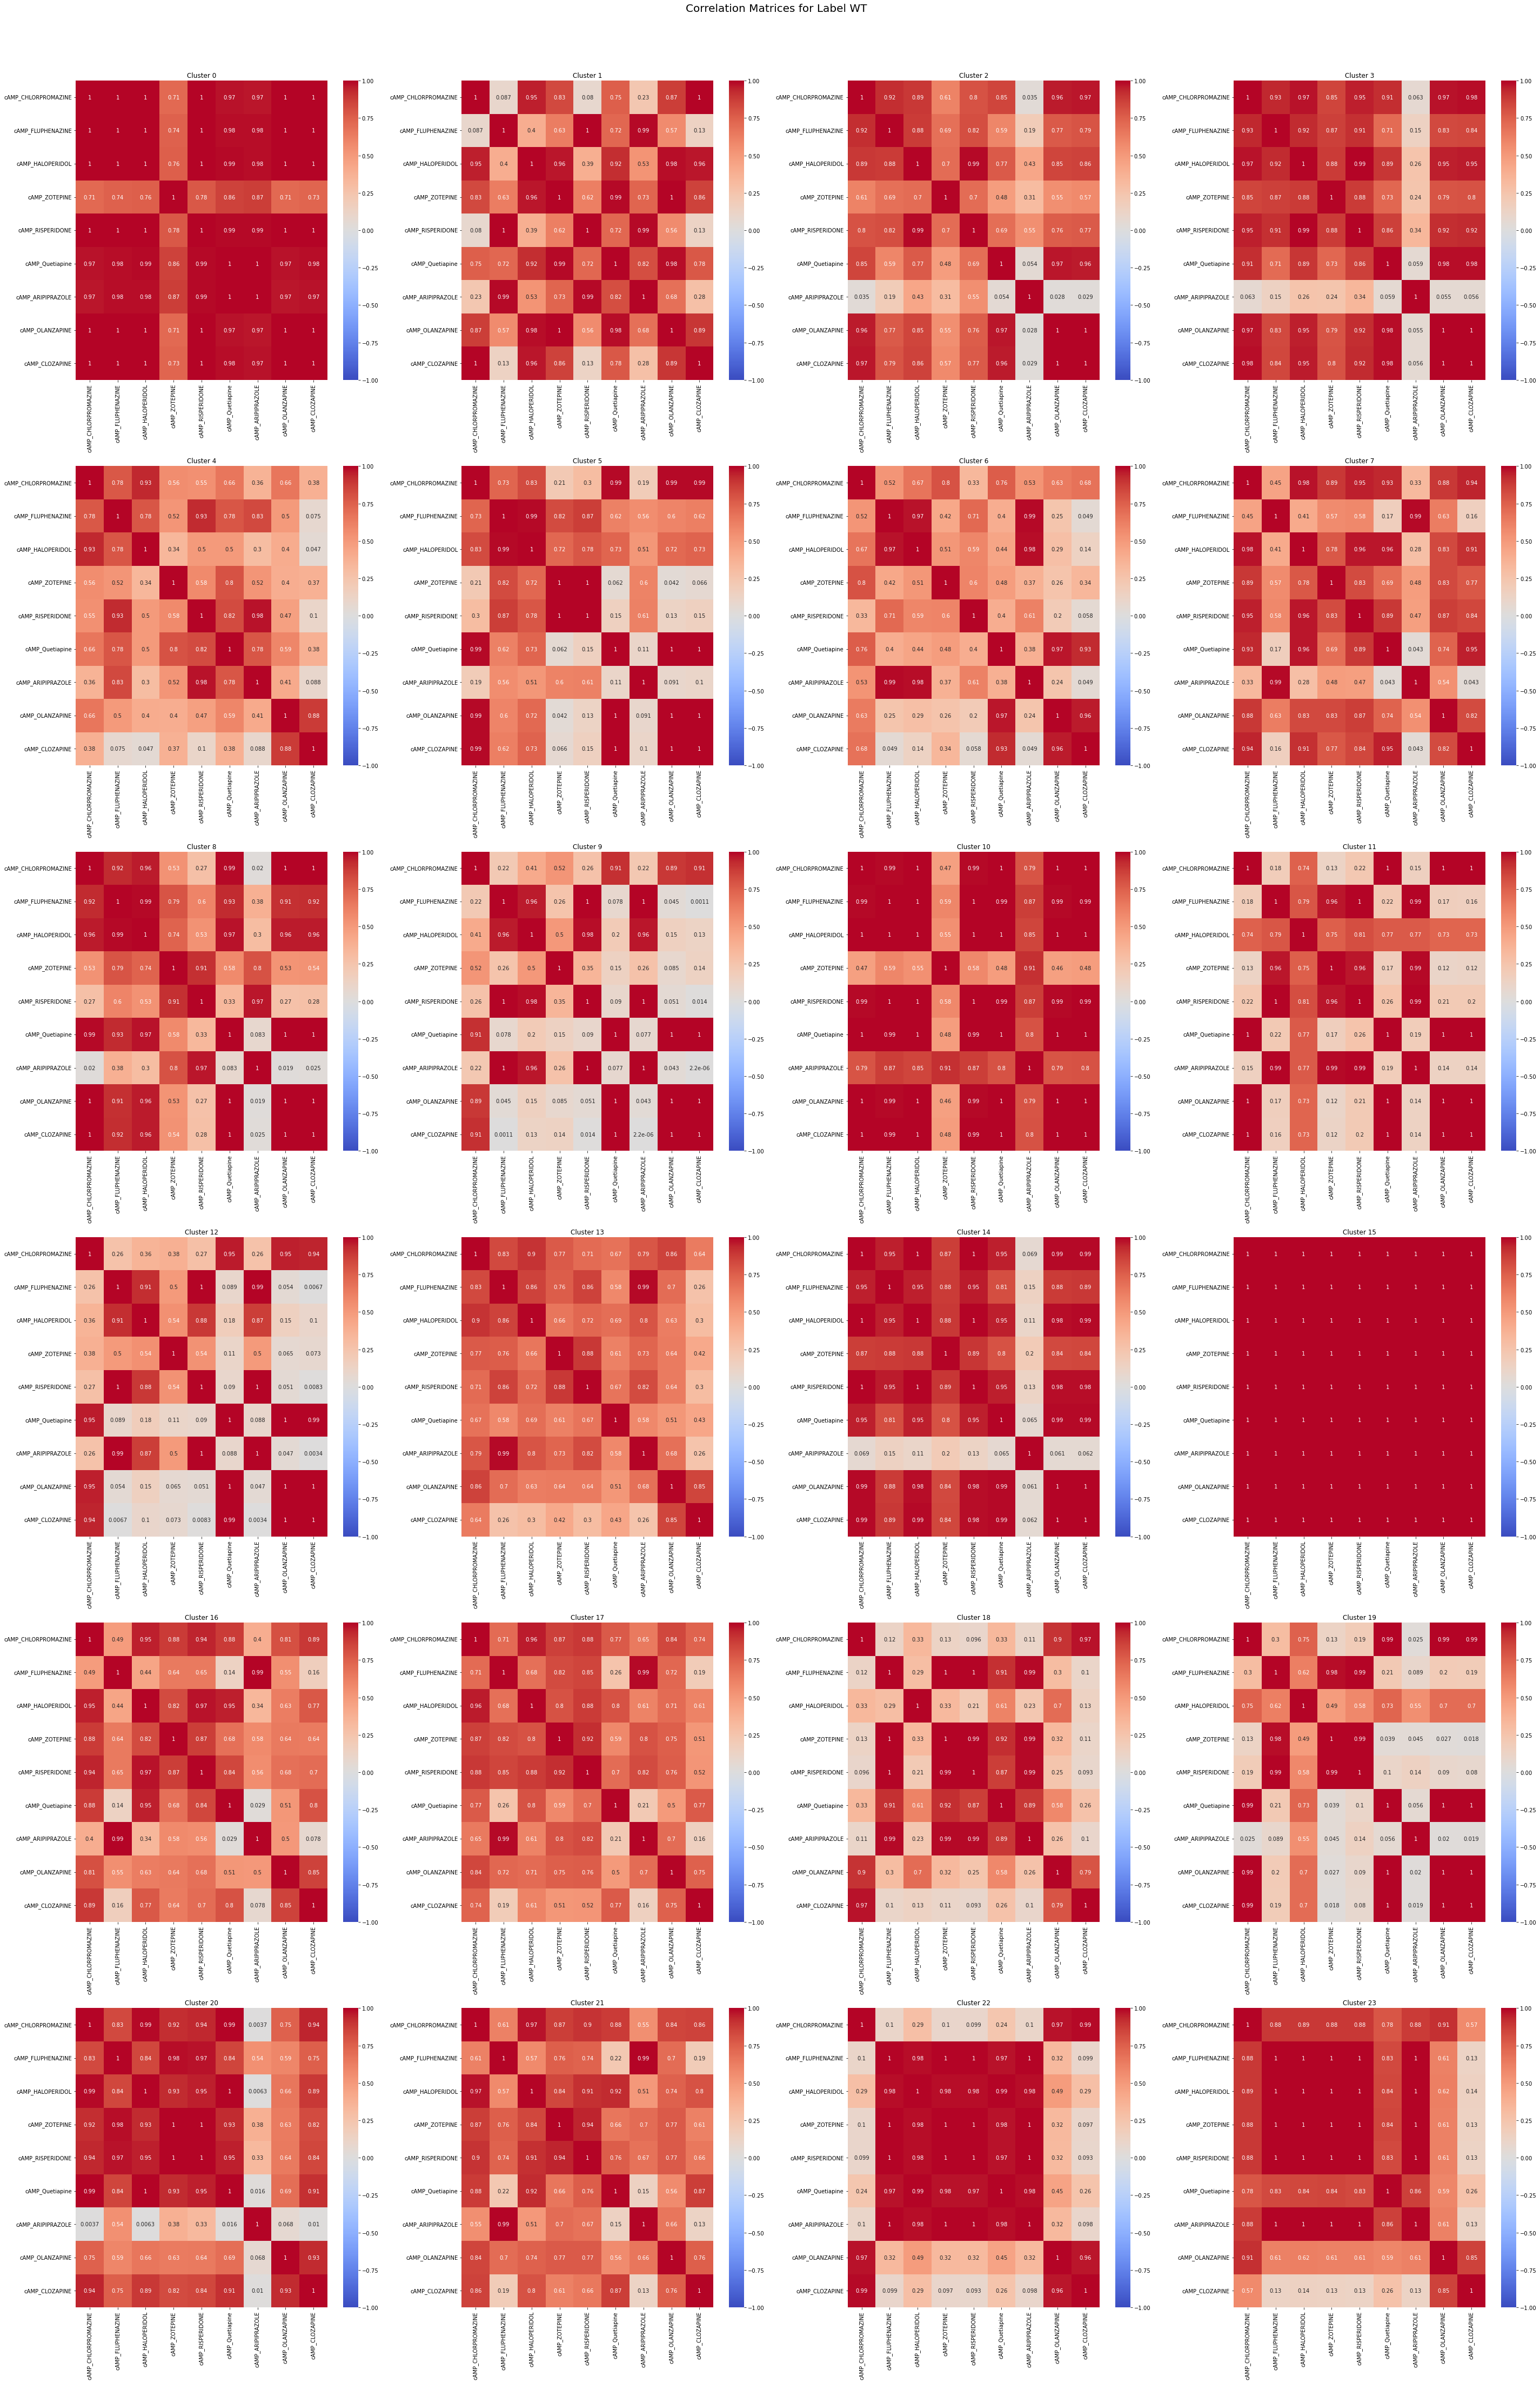

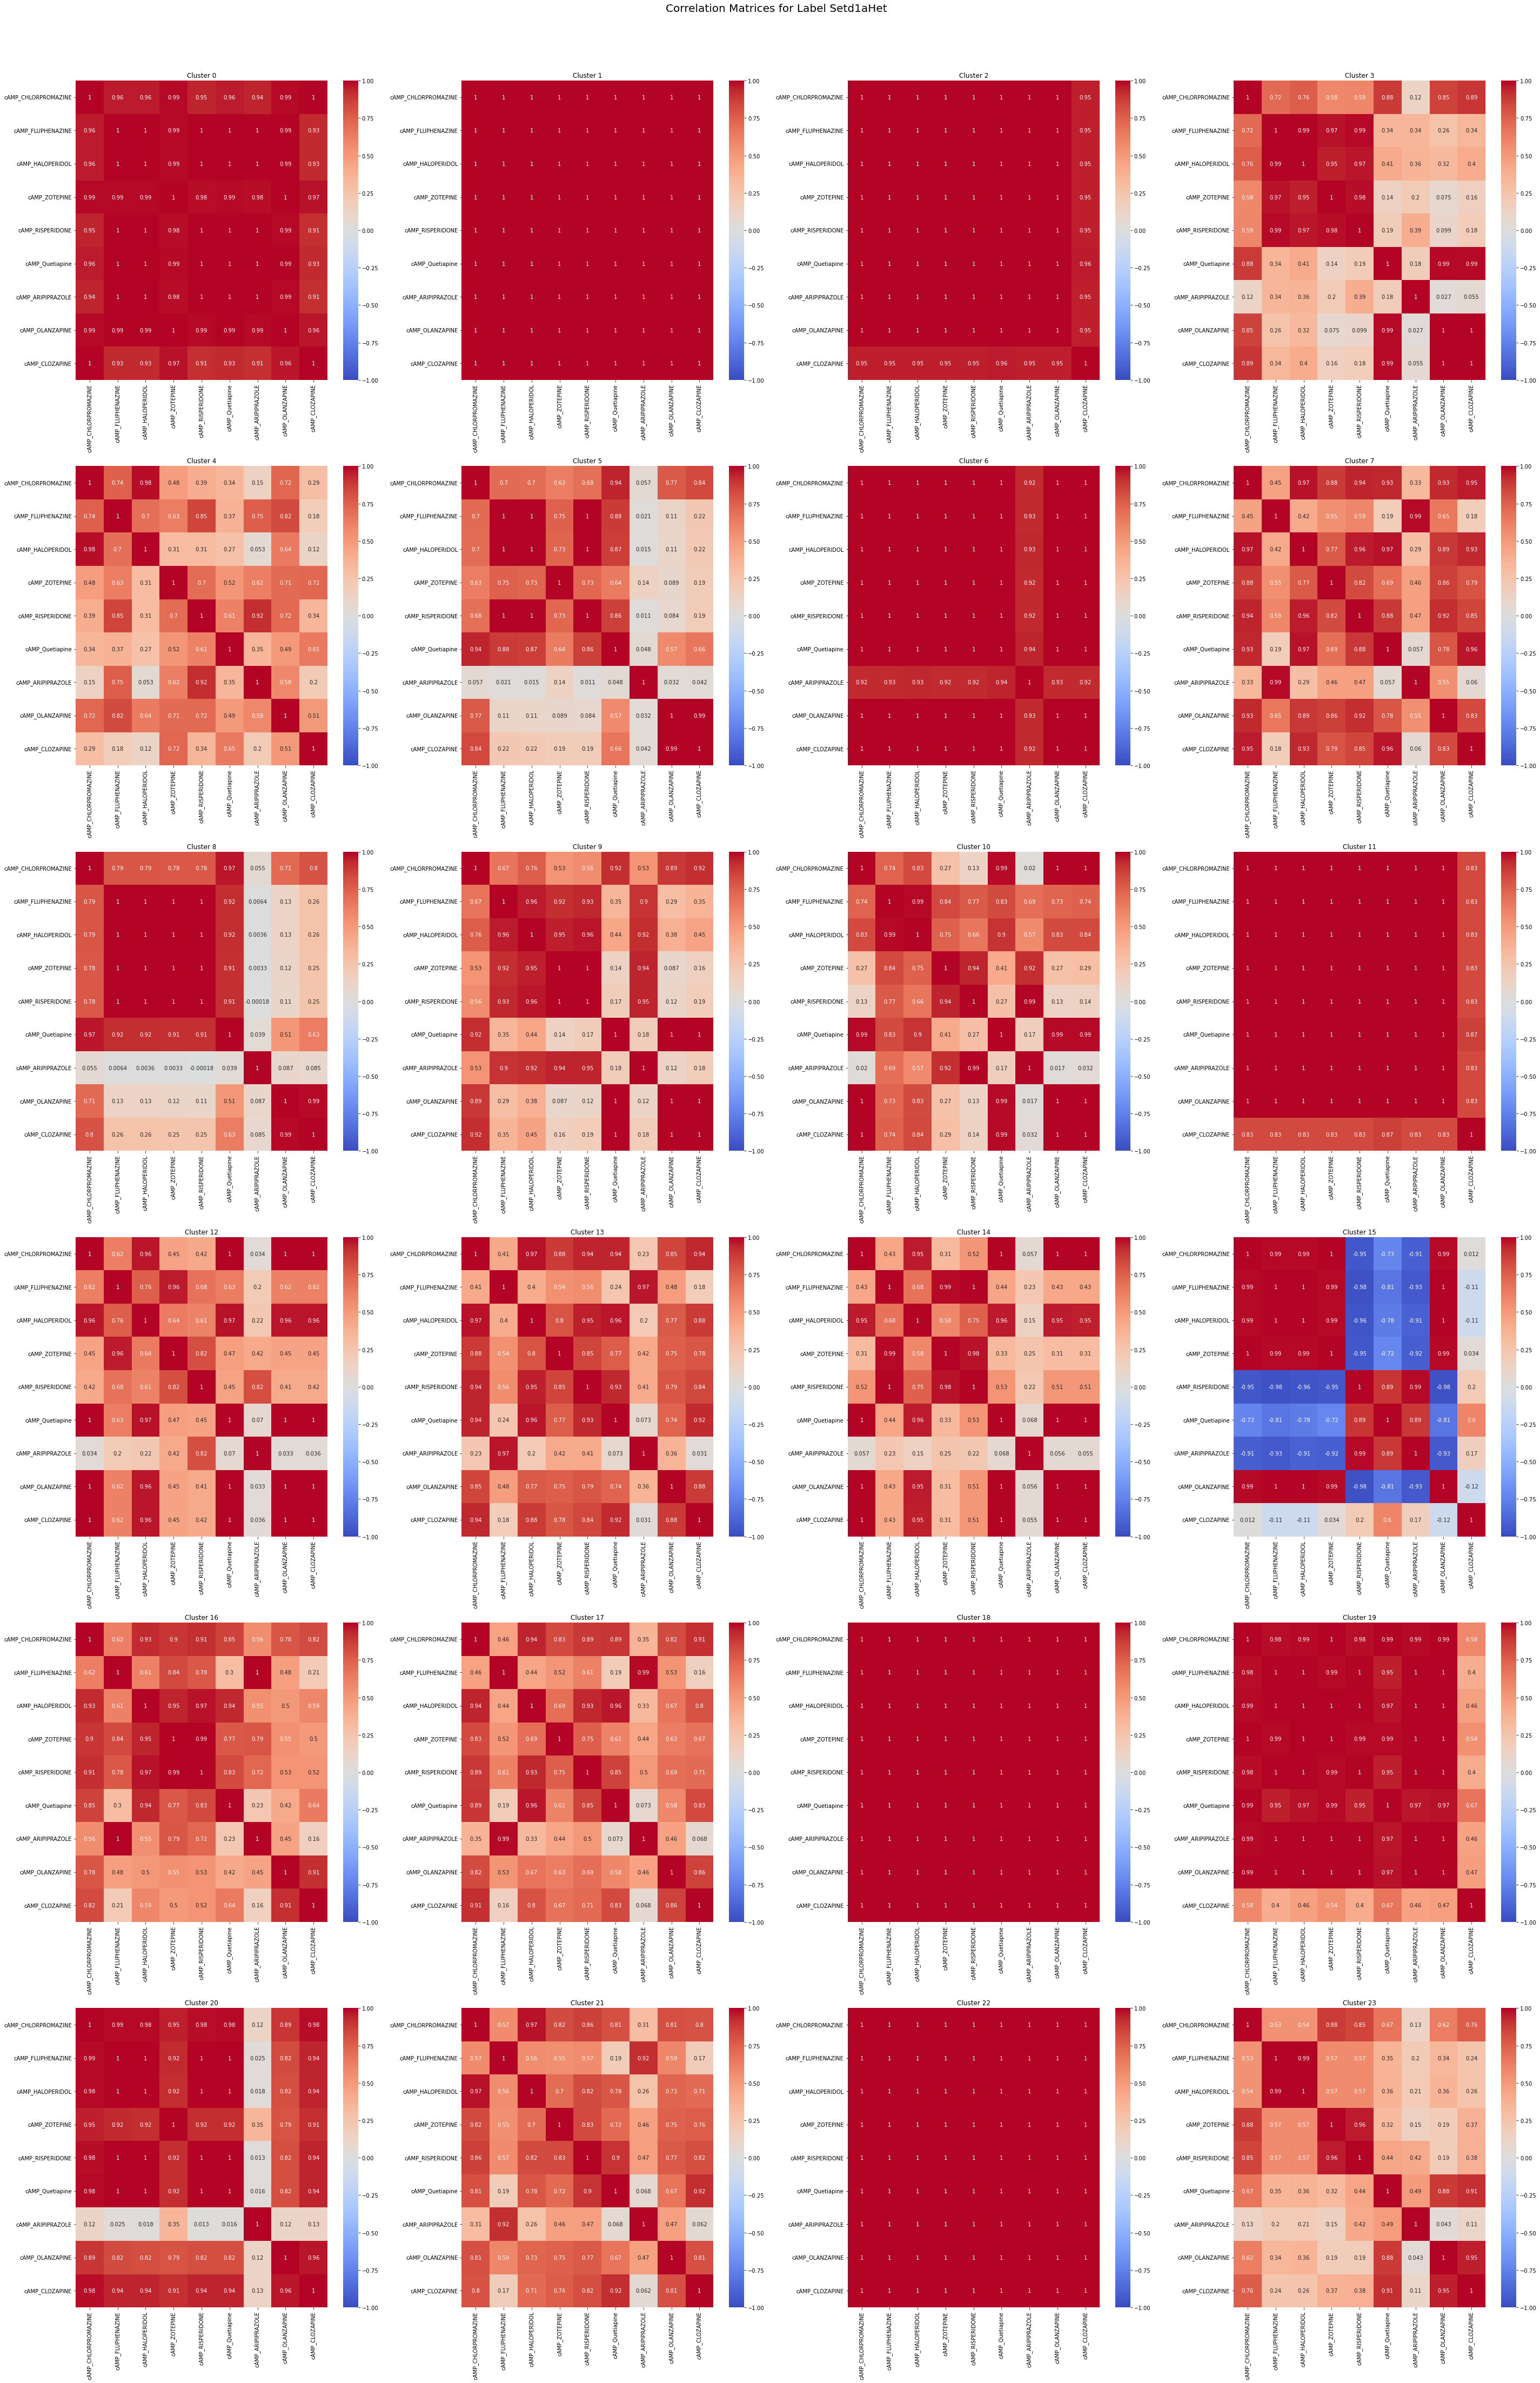

In [15]:
import matplotlib.gridspec as gridspec
import math

# 1. ラベル毎に処理するための準備
unique_labels = adata.obs['label'].unique()

# 2. 各ラベルについて、各クラスタの薬剤反応の相関行列を計算
drug_response_columns = ['cAMP_%s' % drug for drug in drug_list]

# ラベル毎の相関行列を保存するための辞書
correlation_matrices_per_label = {}

for label in unique_labels:
    adata_subset = adata[adata.obs["label"] == label]  # ラベルに基づいてadataのサブセットを取得
    
    # サブセット内のクラスタを取得
    clusters = adata_subset.obs['leiden'].cat.categories
    correlation_matrices = {}
    
    for cluster in clusters:
        subset = adata_subset.obs.loc[adata_subset.obs['leiden'] == cluster, drug_response_columns]
        correlation_matrices[cluster] = subset.corr()
    
    correlation_matrices_per_label[label] = correlation_matrices

# 3. 各ラベルの相関行列を1つのFigureにまとめてプロット
for label, correlation_matrices in correlation_matrices_per_label.items():
    num_clusters = len(correlation_matrices)
    
    # 4つのクラスタごとに新しい行を作成する
    rows = math.ceil(num_clusters / 4)
    fig = plt.figure(figsize=(40, rows * 10))  # 1つの相関行列あたりの横幅を10として計算
    spec = gridspec.GridSpec(rows, 4, figure=fig)  # 4列のグリッドを作成
    
    for i, (cluster, corr_matrix) in enumerate(correlation_matrices.items()):
        ax = fig.add_subplot(spec[i // 4, i % 4])
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
        ax.set_title(f'Cluster {cluster}')
    
    fig.suptitle(f'Correlation Matrices for Label {label}', fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

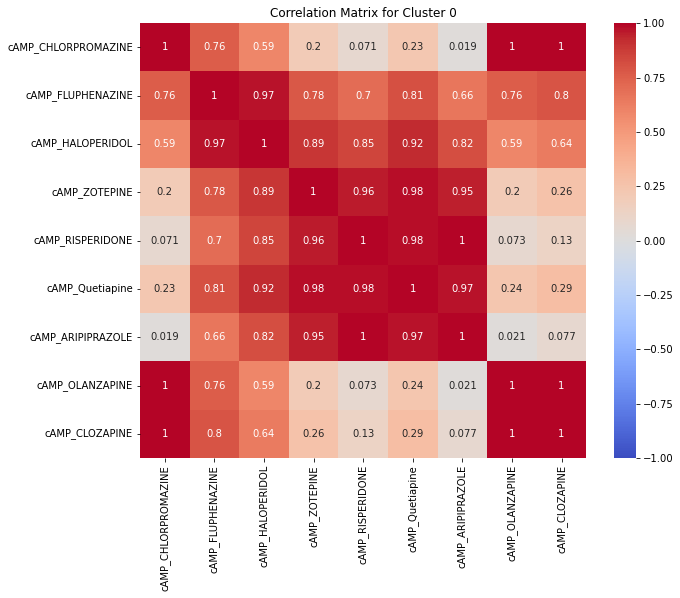

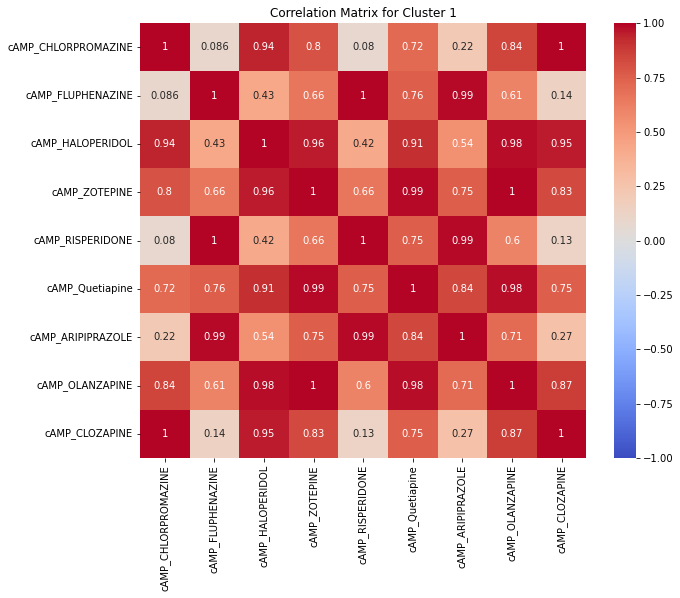

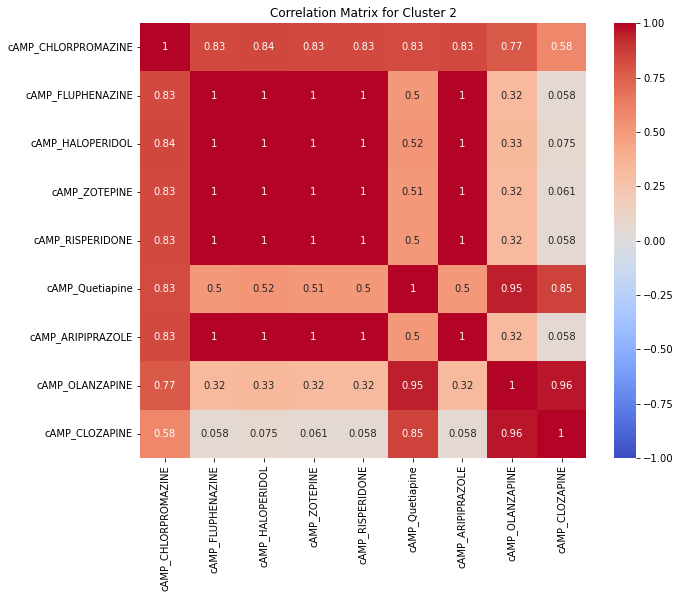

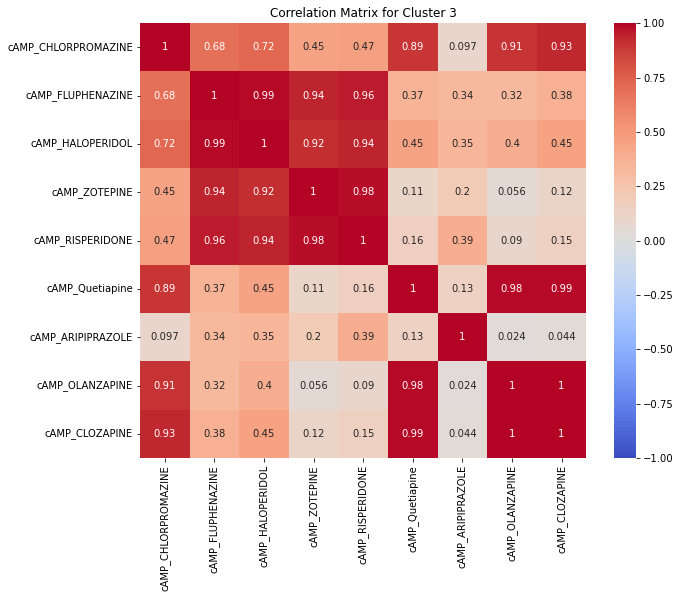

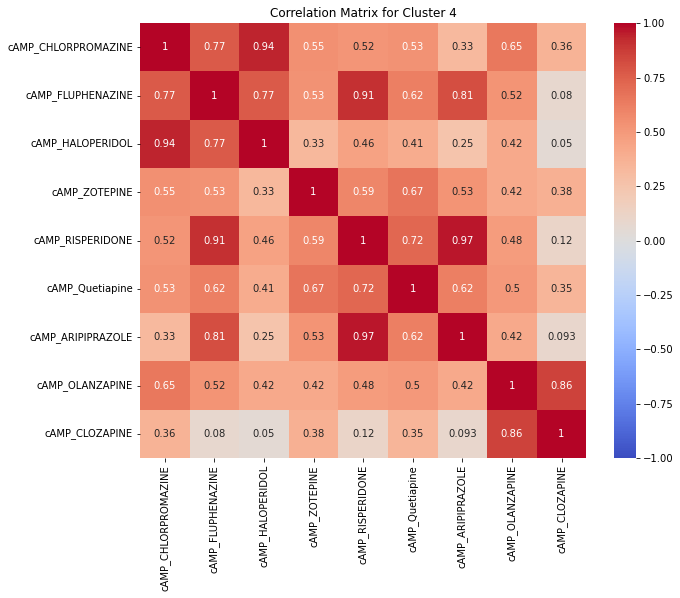

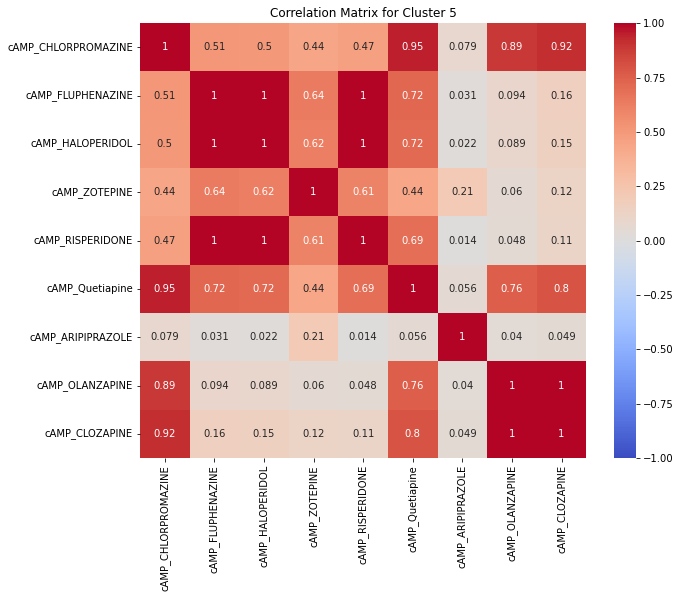

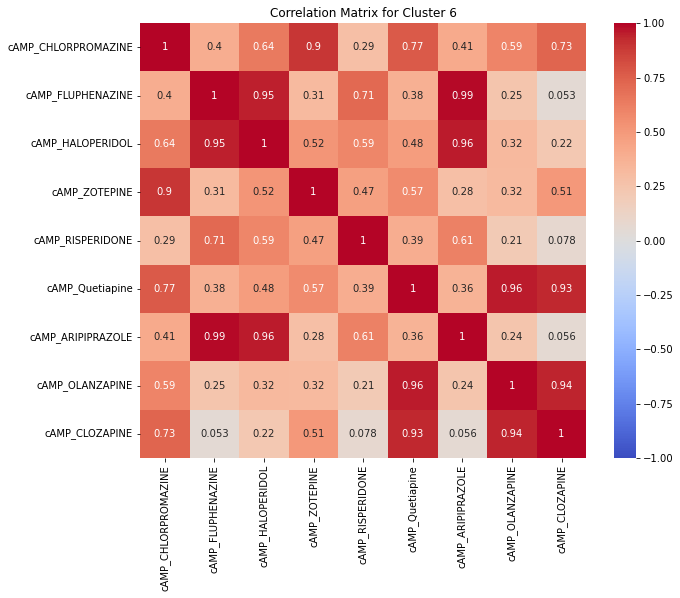

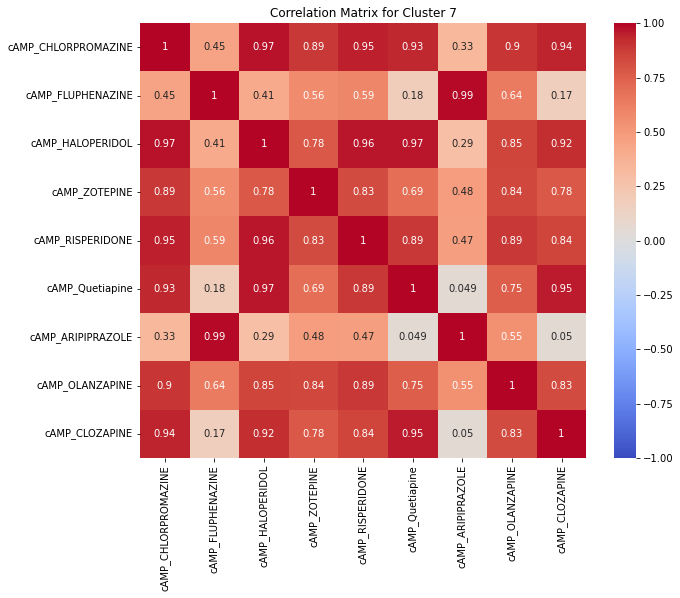

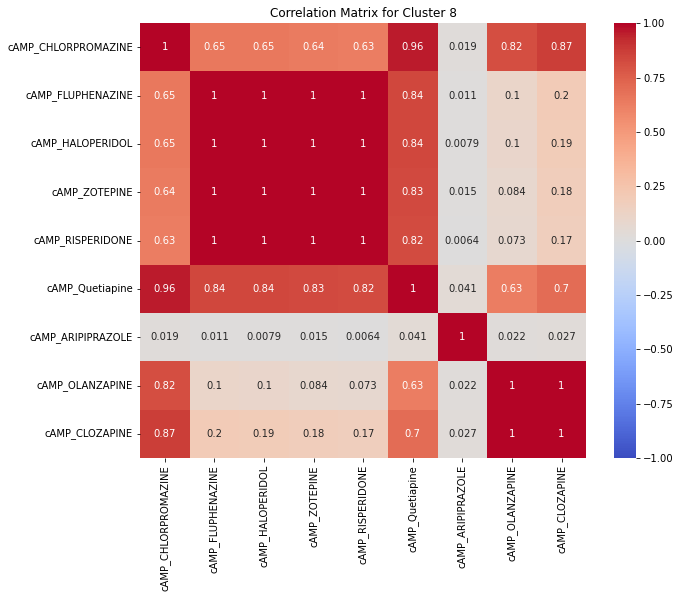

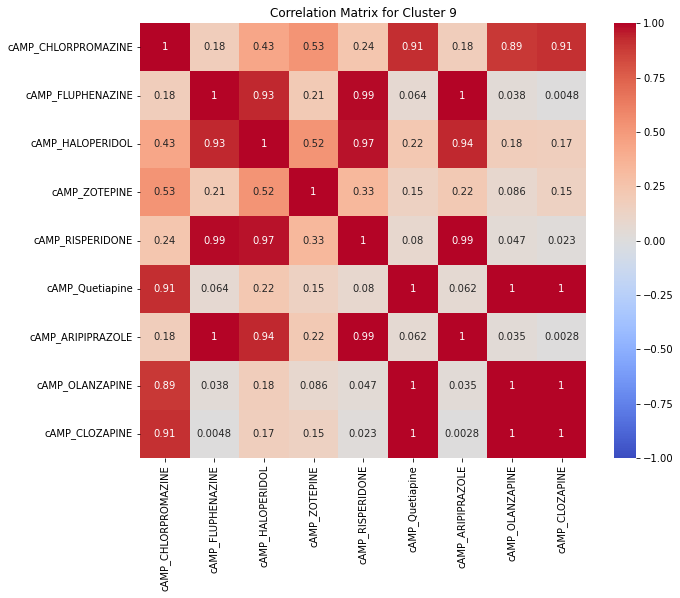

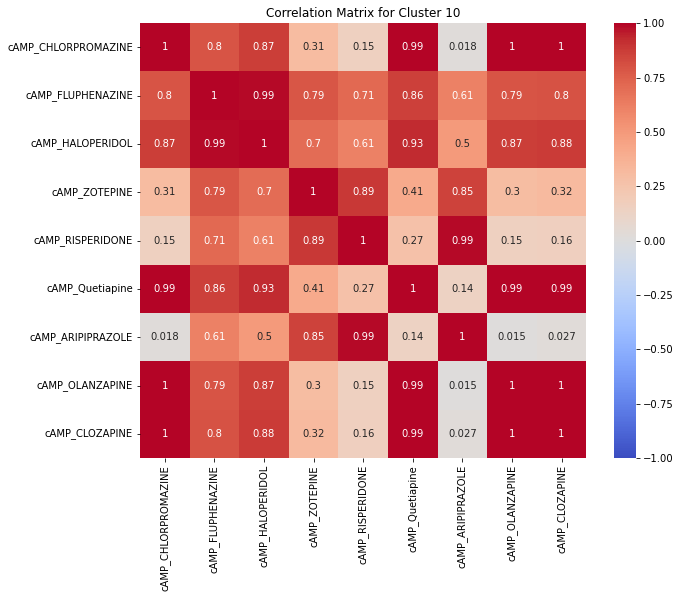

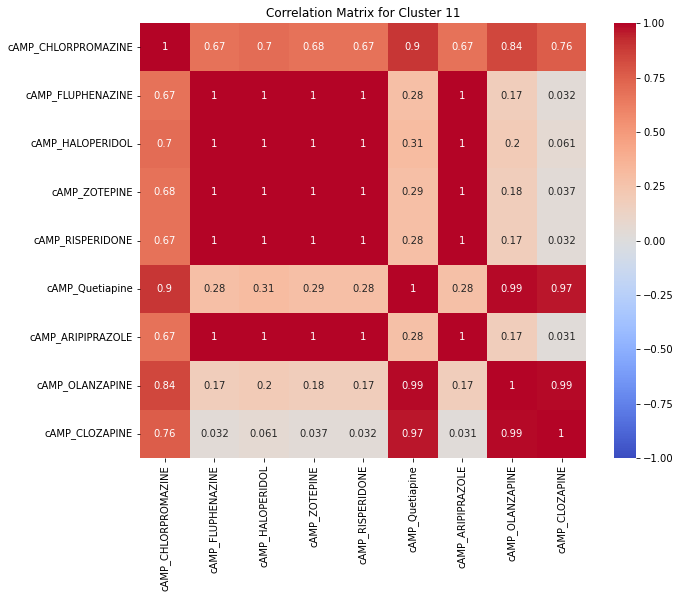

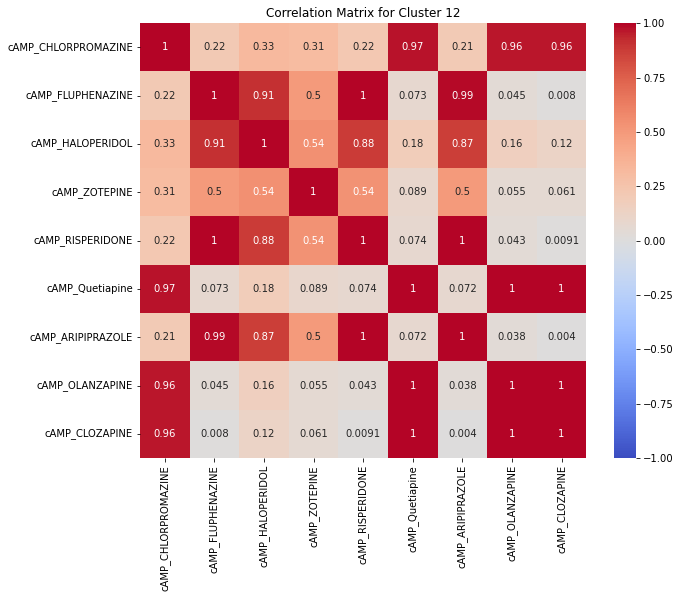

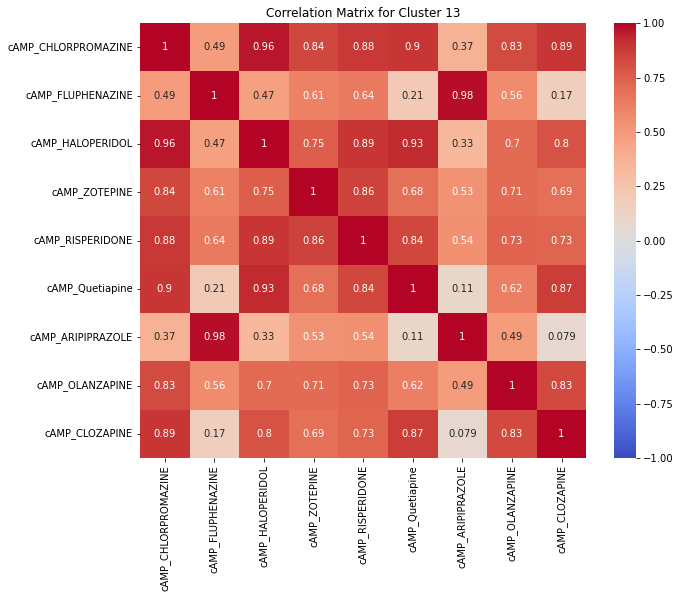

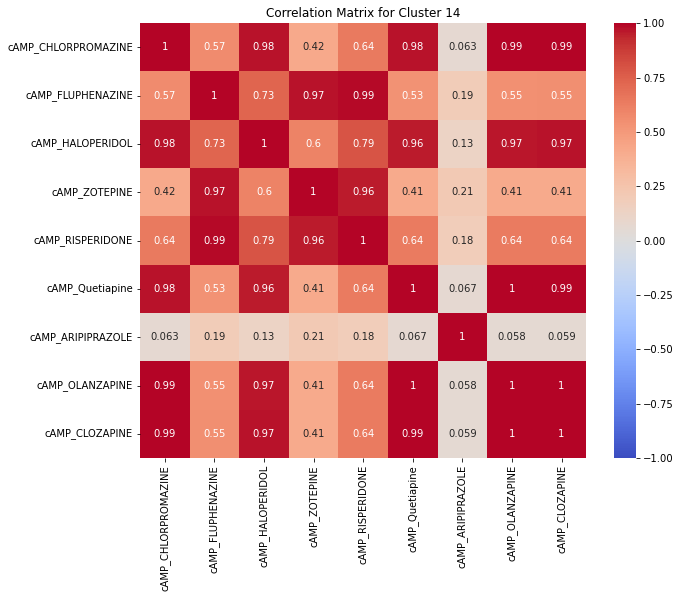

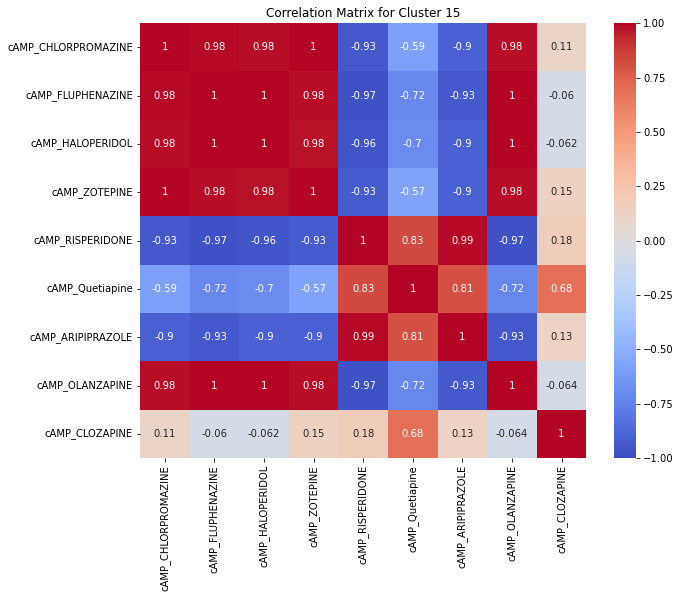

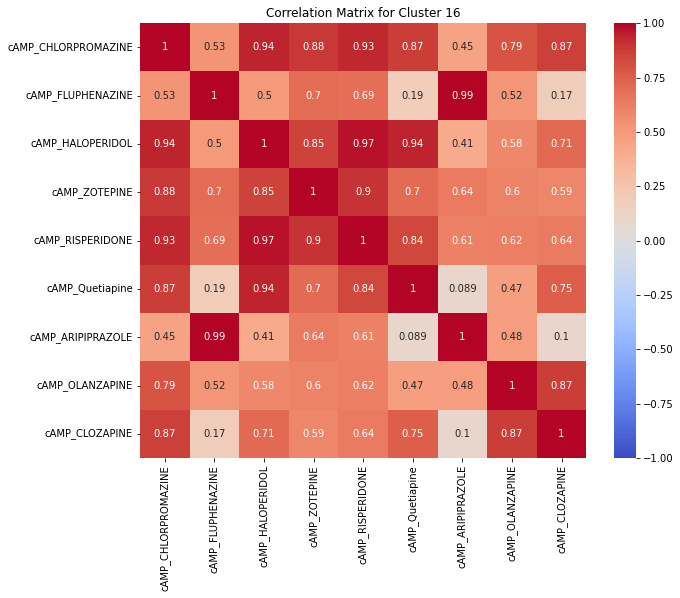

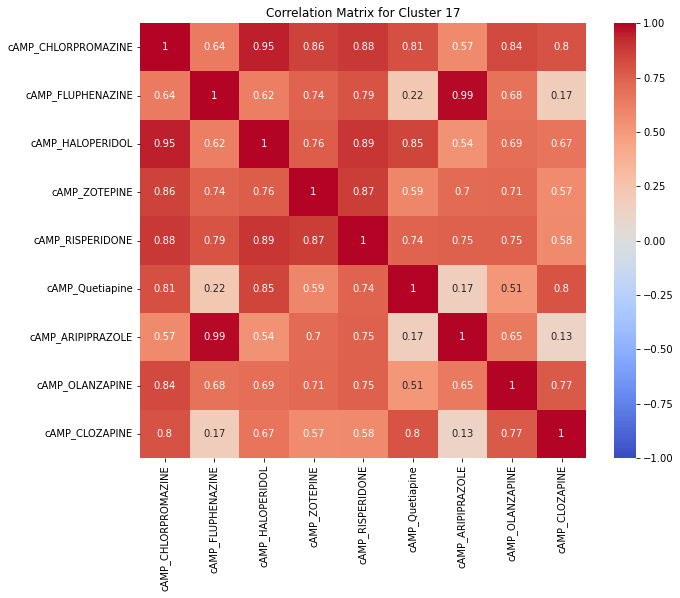

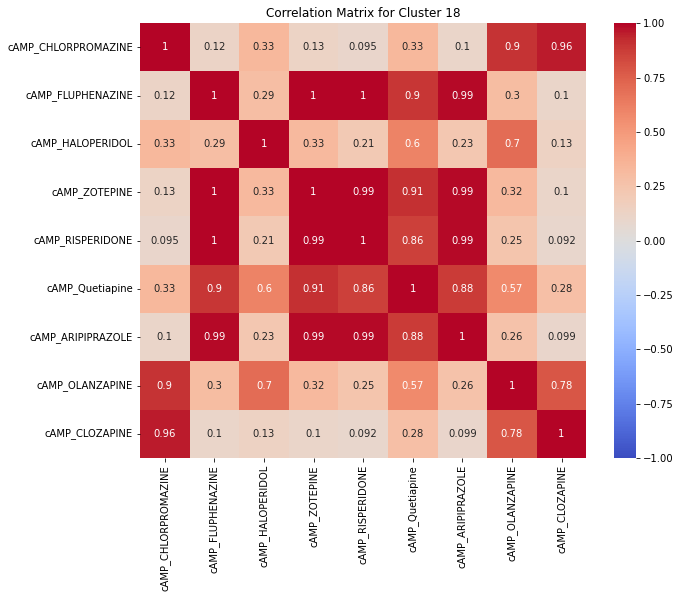

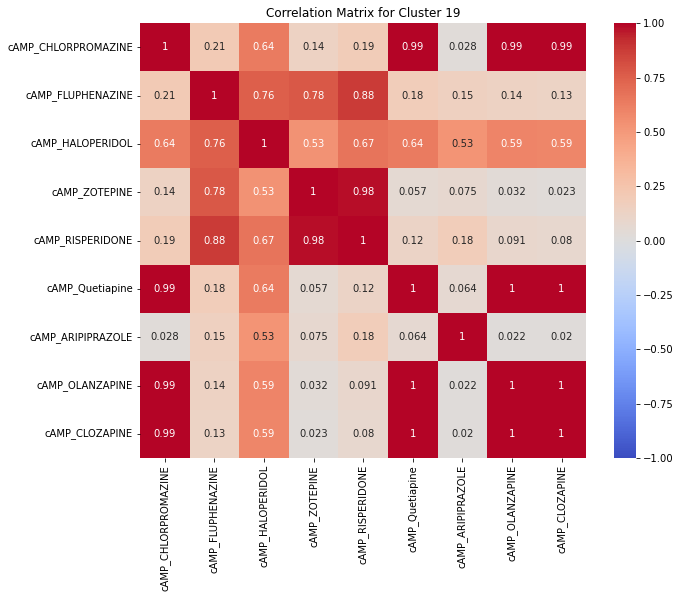

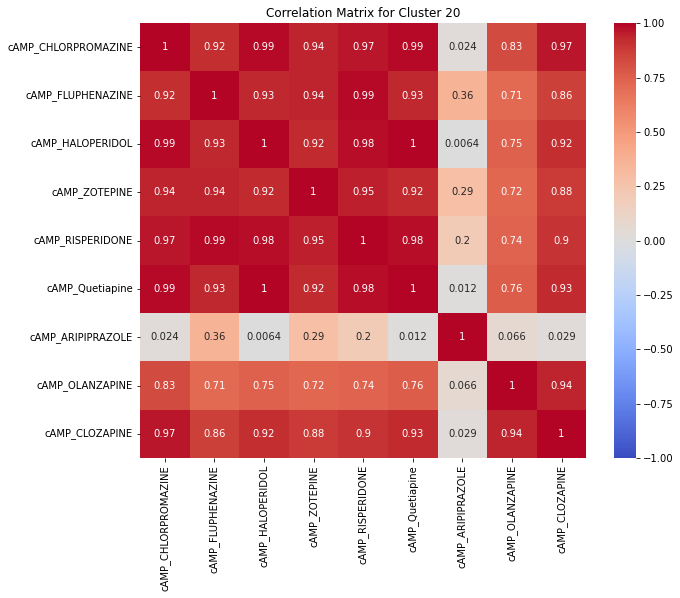

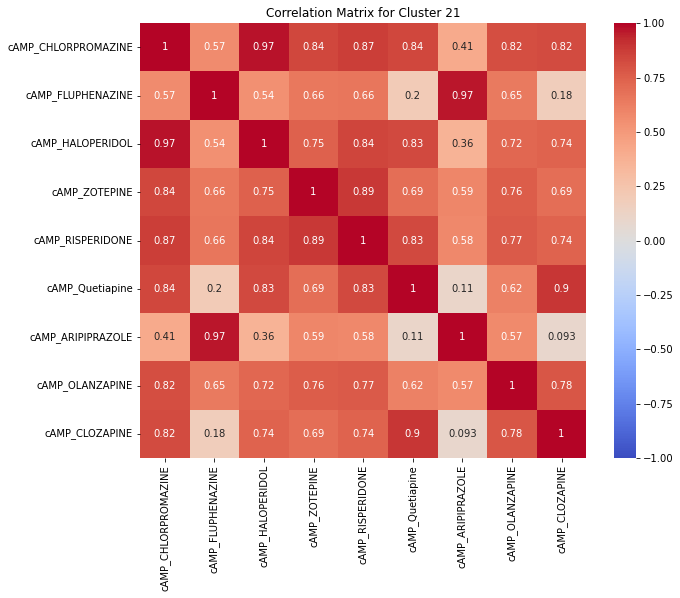

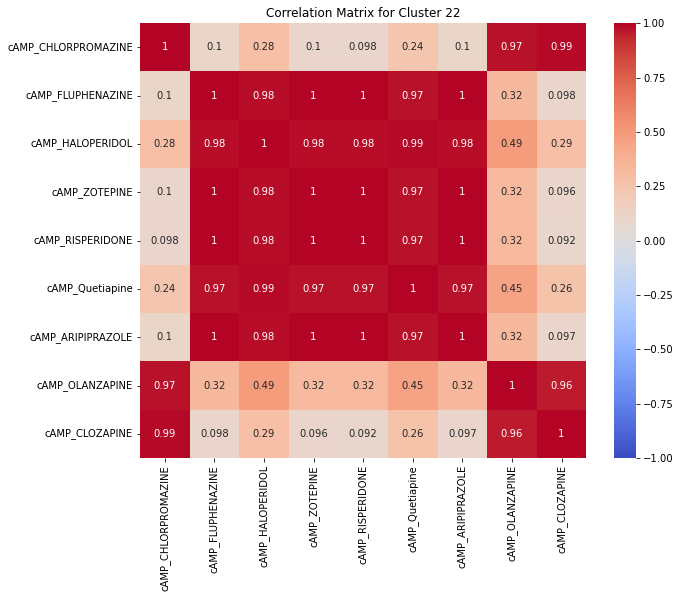

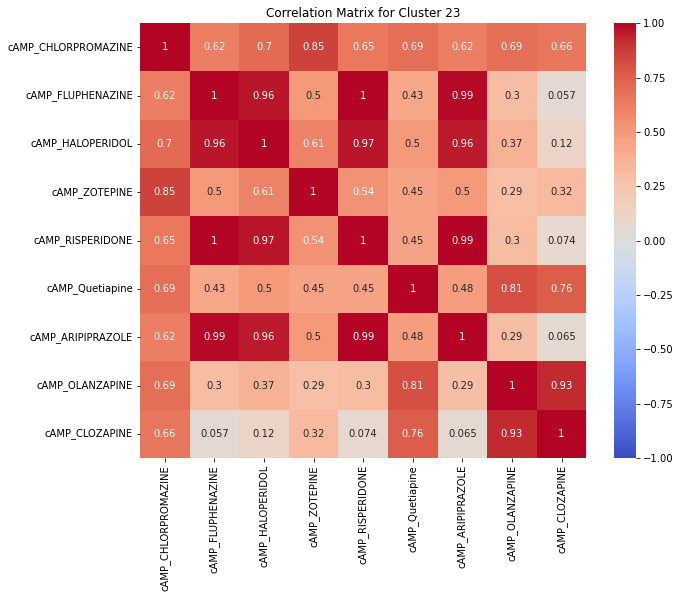

In [11]:
# 3. 各クラスタの薬剤反応の相関行列を計算
drug_response_columns = ['cAMP_%s' % drug for drug in drug_list]

correlation_matrices = {}
clusters = adata.obs['leiden'].cat.categories

for cluster in clusters:
    subset = adata.obs.loc[adata.obs['leiden'] == cluster, drug_response_columns]
    correlation_matrices[cluster] = subset.corr()

# 4. 相関行列をプロット
for cluster, corr_matrix in correlation_matrices.items():
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix for Cluster {cluster}')
    plt.show()

In [ ]:
sc.tl.rank_genes_groups(adata_processed, groupby='leiden', method='wilcoxon')

In [ ]:
# adataからobs_namesを取得
var_names = adata.var_names.tolist()

# obs_namesに含まれる要素だけをgene_of_interestから残す
filtered_genes = [gene for gene in params['markers'] if gene in var_names]
print(filtered_genes)
sc.pl.dotplot(adata, var_names=filtered_genes, groupby='leiden')

In [ ]:
# Leidenクラスタの一覧を取得
clusters = adata.obs['leiden'].unique().tolist()

# 各クラスタの相関係数を格納するリスト
correlations = []

# 各クラスタごとに相関係数を計算
for cluster in clusters:
    subset = adata[adata.obs['leiden'] == cluster]
    correlation = np.corrcoef(subset.obs['cAMP_CLOZAPINE'], subset.obs['cAMP_OLANZAPINE'])[0, 1]
    correlations.append(correlation)

# 相関係数をプロット
plt.figure(figsize=(10, 6))
sns.barplot(x=clusters, y=correlations, palette="viridis")
plt.title("Correlation between cAMP_Clozapine and cAMP_Olanzapine for each cluster")
plt.xlabel("Cluster")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
sc.pl.dotplot(adata, var_names=params['markers'], groupby='leiden')

In [ ]:
adata=adata_processed

In [ ]:
sc.pl.tsne(adata, color=["kmeans"])

In [ ]:
print(adata.obs["is_clz_activated"].dtype)

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6,6), gridspec_kw={'wspace':0.2})
sc.pl.umap(adata, color=["is_clz_selective"],ax=ax1,palette=["gray","red"])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.tight_layout()
#fig.savefig("../data/mouse_PFC/pdf/clz_selective_scatter.pdf",bbox_inches='tight')
#fig.savefig("../data/mouse_PFC/pdf/clz_selective_scatter.png",bbox_inches='tight')
plt.close()

In [ ]:
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

In [ ]:
sc.tl.rank_genes_groups(adata, 'is_clz_selective', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False,save="clz_selective_over_olz_genes_mouse_PFC.pdf")

In [ ]:
file_path="/temp/data/mouse_PFC/WT_PFC_GPCR_adata.h5ad"
GPCR_adata.write(file_path)

In [ ]:
file_path="/temp/data/mouse_PFC/WT_PFC_adata.h5ad"
adata.write(file_path)

In [ ]:
adata.obs

In [ ]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_activated')

In [ ]:
sc.tl.rank_genes_groups(adata, 'is_clz_inhibited', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

In [ ]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_inhibited')

In [ ]:
sc.tl.rank_genes_groups(adata, 'is_clz_selective', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

In [ ]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_selective')

In [ ]:
%%time
for drug in drug_list:
    sc.pl.violin(adata, "cAMP_%s"%drug, groupby='leiden',stripplot=True,log=True)